# Applying PCA on tittles

**Motivation:** squeeze titles clusters into 20D

### loads

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import seaborn as sns

import set_path
import supp.support_load as sl
from supp.support_load import read_csv, read_excel
from supp.support_merge import merge, group_to_list
from supp.support_save import save_df
from supp.support_constants import VIZIER_IDS, PATH_DATA_MERGED

In [2]:
titles_to_omit = ['cHD Hm(w)-nTr Mn-nfr-Ppy', 'imy-rA niwt (mr)', 'imy-rA Hwt-wrt 6']

In [3]:
titles_viziers = ['tAyty TAty (n) zAb', 'tAyty zAb ', 'tAyty TAty (n) zAb mAa']

In [4]:
response = 'vizier'

In [5]:
# load whole dataframe
df_titles = read_csv('vizier__35_title_list')
print(f'{df_titles.shape}\t shape')
df_titles.head()

CSV file loaded.
C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\unpacked\df_person_all\merged\vizier__35_title_list.csv
(4962, 2184)	 shape


,ID_person,vizier,(cmcw ?) wxrt aAt,(wnn) imAx.c nfr xr Ra nb Axt(y),... 1p,... BA-Nfr-ir-kA-ra,... Hct n xnt[yw-S],... Hm(w)-nTr ... m Cxt-Ra,... Hm-kA,... Hm-nTr 1wt-1r,...,zmAwt mry Nbty ncwt,zwnw,zwnw Xt pr-aA,zwnw cmcw pr-aA,zwnw irty,zwnw irty pr-aA,zwnw pr-aA,zš (n) (i)m(yw) zA 20 (n) niwt mr,zš (n) (i)m(yw) zA 20 (n) niwt mr Mn-anx-Nfr-kA-ra,zš wab 200 pr-aA
0,322,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,323,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,324,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,325,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,326,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# load test, val, test sets to get their indexes
df_train = sl.read_csv('df_vizier_title_train_v1_mod') 
df_val = sl.read_csv('df_vizier_title_val_v1_mod') 
df_test = sl.read_csv('df_vizier_title_test_v1_mod') 
df_train_v2 = sl.read_csv('df_vizier_title_train_v2_mod') 

CSV file loaded.
C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\df_vizier_title_train_v1_mod.csv
CSV file loaded.
C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\df_vizier_title_val_v1_mod.csv
CSV file loaded.
C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\df_vizier_title_test_v1_mod.csv
CSV file loaded.
C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\df_vizier_title_train_v2_mod.csv


In [7]:
# move column from sets v1 and v2 first
features_v1 = df_train.columns.to_list()
features_v2 = df_train_v2.columns.to_list()
features_order_models = features_v1 + [el for el in features_v2 if el not in features_v1]
features_order = features_order_models + [el for el in df_titles.columns if el not in features_order_models]
new_order = [el for el in features_order if el in df_titles.columns]
len(features_order)
# reorder titles
df_titles = df_titles[new_order]
print(df_titles.shape)

(4962, 2184)


In [8]:
# get indexes of train, val, test sets
person_id_train = df_train['ID_person'].to_list()
person_id_val = df_val['ID_person'].to_list()
person_id_test = df_test['ID_person'].to_list()
person_id_all = person_id_train + person_id_val + person_id_test

print(f'{len(person_id_train)}\t len of person_id_train')
print(f'{len(person_id_val)}\t len of person_id_val')
print(f'{len(person_id_test)}\t len of person_id_test')
print(f'{len(person_id_all)}\t len of person_id_all')

2693	 len of person_id_train
582	 len of person_id_val
574	 len of person_id_test
3849	 len of person_id_all


In [9]:
# save response with indexes
y_true = df_titles[['ID_person', 'vizier']].set_index('ID_person')

### functions

In [10]:
def conditional_probability(df, col1, col2):
    """
    Calculate the conditional probability P(col1=1 | col2=1) in a binary dataframe.
    
    Args:
    df (pd.DataFrame): Input DataFrame with binary values (0 or 1).
    col1 (str): The column for which probability is calculated (dependent variable).
    col2 (str): The column given as condition (independent variable).

    Returns:
    float: The conditional probability P(col1=1 | col2=1)
    """
    # If col1 or col2 is not valid column name, return nan
    if col1 not in df.columns or col2 not in df.columns:
        return np.nan
    
    # Count occurrences where both col1 and col2 are 1
    joint_count = ((df[col1] == 1) & (df[col2] == 1)).sum()
    
    # Count occurrences where col2 is 1
    col2_count = (df[col2] == 1).sum()
    
    # Compute conditional probability
    if col2_count == 0:
        return 0  # Avoid division by zero

    probability = joint_count / col2_count
    return round(probability, 4)

In [11]:
# drop column with high correlation
def drop_high_corr(df_original):
    df = df_original.copy()
    
    corr_matrix = df.corr().abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
    df.drop(columns=to_drop, inplace=True)

    print(f'Dropped {len(to_drop)} features')
    return df, to_drop

In [12]:
# drop column with high VIF (Variance Inflation Factor)
def drop_high_vif(df, thresh):
    X = df.copy()
    dropped = []
    
    while True:
        X_with_const = add_constant(X)
        vif_list = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
        vif = pd.Series(vif_list, index=X_with_const.columns)

        # Exclude intercept
        vif_no_const = vif.drop("const")

        if vif_no_const.max() <= thresh:
            break

        # Sort values
        vif = vif.sort_values().sort_index(kind="stable")
        
        feature_to_drop = vif_no_const.idxmax()
        print(f"\tDropping '{feature_to_drop}' with VIF={vif_no_const.max():.2f}")
        X = X.drop(columns=[feature_to_drop])
        dropped.append(feature_to_drop)

    return X, dropped

### dataset restrictions

In [13]:
# drop titles in omission (hight correlation with vizier)
df = df_titles.copy()
print(f'{df.shape}\t shape original')
df.drop(titles_to_omit, axis=1, inplace=True)
print(f'{df.shape}\t shape afer omission')
print(f'count of omitted features: {len(titles_to_omit)}')
print(titles_to_omit)

(4962, 2184)	 shape original
(4962, 2181)	 shape afer omission
count of omitted features: 3
['cHD Hm(w)-nTr Mn-nfr-Ppy', 'imy-rA niwt (mr)', 'imy-rA Hwt-wrt 6']


In [14]:
# drop vizier titles
print(f'{df.shape}\t shape original')
df.drop([el for el in titles_viziers if el in df.columns], axis=1, inplace=True)
print(f'{df.shape}\t shape afer omission')
print(f'count of vizier features: {len(titles_viziers)}')
print(titles_viziers)

(4962, 2181)	 shape original
(4962, 2179)	 shape afer omission
count of vizier features: 3
['tAyty TAty (n) zAb', 'tAyty zAb ', 'tAyty TAty (n) zAb mAa']


In [15]:
# restrict to ID_person of persons in test, val or test set
df = df.loc[df_titles['ID_person'].isin(person_id_all), :]
print(f'{df.shape}\t shape original')
df.set_index('ID_person', inplace=True)
print(f'{df.shape}\t shape final')
df.head(2)

(3849, 2179)	 shape original
(3849, 2178)	 shape final


,vizier,r P nb,mniw Nxn / zAw Nxn,imy-rA wabty,imy-rA 5maw,cmcw cnwt,xrp iAwt nbwt nTrwt,imy-rA prwy-nbw,imAxw,xrp aH,...,zmAwt mry Nbty ncwt,zwnw,zwnw Xt pr-aA,zwnw cmcw pr-aA,zwnw irty,zwnw irty pr-aA,zwnw pr-aA,zš (n) (i)m(yw) zA 20 (n) niwt mr,zš (n) (i)m(yw) zA 20 (n) niwt mr Mn-anx-Nfr-kA-ra,zš wab 200 pr-aA
ID_person,,,,,,,,,,,,,,,,,,,,,
322,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
323,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# drop titles with too low count
print(f'{df.shape}\t shape original')
mask = df.sum(axis=0) >= 3
df = df.loc[:, mask]
print(f'count of omitted features: {len(mask) - mask.sum()}')
print(f'{df.shape}\t shape final')

(3849, 2178)	 shape original
count of omitted features: 1607
(3849, 571)	 shape final


In [17]:
# drop duplicated columns
print(f'{df.shape}\t shape original')
df = df.loc[:, ~df.T.duplicated()]
print(f'{df.shape}\t shape final')

(3849, 571)	 shape original
(3849, 571)	 shape final


In [18]:
# drop titles with P(title|vizier) == 0
# print(f'{df.shape}\t shape original')
# dropped_prob = []
# for col in df.columns:
#     p_title_vezier = conditional_probability(df, col, response)
#     if p_title_vezier == 0:
#         df.drop(col, axis=1, inplace=True)
#         dropped_prob.append(col)
#         #print(f'{col} removed')
# print(f'{df.shape}\t shape final')
# print(f'count of omitted features: {len(dropped_prob)}')
# print(f'{dropped_prob=}')
# print(df.shape)

In [19]:
# remove response from dataframe
df = df[[col for col in df.columns if col != response]]

In [20]:
# drop columns with too high correlation
print(f'{df.shape}\t shape original')
df, dropped_corr = drop_high_corr(df)
print(f'{df.shape}\t shape final')
print(f'count of omitted features: {len(dropped_corr)}')
print(f'{dropped_corr=}')

(3849, 570)	 shape original
Dropped 0 features
(3849, 570)	 shape final
count of omitted features: 0
dropped_corr=[]


In [21]:
# save currenct state of dataframe
# this file will be used in R script 'df_remove_VIF'
df1 = pd.merge(y_true, df, left_index=True, right_index=True, how='right')
save_df(df1, 'df_vizier_title_v3_preprocessing.csv')
print(df1.shape)
df1.head()

Dataframe saved into C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\df_vizier_title_v3_preprocessing.csv
(3849, 571)


,vizier,r P nb,mniw Nxn / zAw Nxn,imy-rA wabty,imy-rA 5maw,cmcw cnwt,xrp iAwt nbwt nTrwt,imy-rA prwy-nbw,imAxw,xrp aH,...,zS pr-aA,zS pr-mDA(w)t,zS pr-mDAt nTr,zS pr-mDAt nTr pr-aA,zS qdw(t),zS wr(w) mD 5maw,zb,zb pr-aA,zwnw,zwnw pr-aA
ID_person,,,,,,,,,,,,,,,,,,,,,
322,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
323,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
324,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
325,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
326,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# load file from script 'df_remove_VIF'
p = r"C:\Users\Stoja\OneDrive\Documents\diplomka\scr\jupyter_notebook\R_script\PCA_20D_aliases.csv"
p_map = r"C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\df_title_name_r_map.csv"

In [23]:
# load map R-names to normal-names
dict_map = pd.read_csv(p_map).set_index('key')['value'].to_dict()
# laod data
data = pd.read_csv(p, index_col=0)
# apply map to indexes and columns
data = data.rename(dict_map, axis=0)
data = data.rename(dict_map, axis=1)
print(data.shape)
data.head()

(0, 0)


""


In [24]:
# define columns that are linear combination of others
#multicollinear_columns = [ 'Hm.1r.5wA', 'Hm.nTr.1r.Ct.ib.tAwy', 'Hm.nTr.1r.Inpw', 'Hm.nTr.3nmw.xnty.pr.zA', 'Hm.nTr.3ry.BAq.f', 'Hm.nTr.BActt.Hryt.xnd', 'Hm.nTr.BAw.Nxn', 'Hm.nTr.Cpdw', 'Hm.nTr.Inpw', 'Hm.nTr.Nwnwt.Nnwt', 'Hry.cStA..n..xAcwt.nbwt', 'Hry.cStA.kAt.nbt.nt.ncwt', 'Hry.cStA.n.mAAt.wa', 'Hry.cStA.n.mdw.StA.w..n.Hwt.wrt', 'Hry.cStA.n.mdw.StA.w..n.Hwt.wrt.6', 'Hry.cStA.n.mdw.StA.w..nw.mdw.nTr', 'Hry.cStA.n.nTr.f.mrrw.nb.f', 'Hry.cStA.n.ncwt.m.cStA.f.nb', 'Hry.cStA.n.pt', 'Hry.cStA.n.wDa.mdw.nb.n.Hwt.wrt', 'Hry.cStA.n.wp.w.t.StAt', 'Hry.tp.Nxb.n.it.f', 'Xry.nwc.n.WADt', 'Xry.Hbt.mAa', 'Xry.Hbt.mit.1r.DAt.1r', 'cHD.Hm.w..nTr.1wt.1r.zA.wr..m..mrt.CAHw.Ra', 'cHD.Hm.w..nTr.9d.cwt.zA.Ra.6ti', 'cHD.Hm.w..nTr.Hwt.kA.Axt', 'cHD.Hm.w..nTr.Mn.cwt.Ny.wcr.Ra', 'cHD.iry.w..mDAt.cStA.t...n..zAb', 'cHD.wab.w..2a.baw.CAHw.Ra', 'cHD.wab.w..ncwt', 'cHD.wabt.pr.aA', 'cHD.wr.w..mD.5maw', 'cHD.xnty.w..S.Nfr.cwt.ncwt.bity.Wnic', 'cHD.xtm.tyw..pr.mDAt.nTr', 'cHD.zwnw.pr.aA', 'cSm.tA.n.Nart.xntt', 'cXkr.HAt.nTr.f', 'cXkr.nTr.f', 'cmr.n.y..ib.nb.f', 'imAxw.mAa', 'imAxw.mAa.mAa.xr.nTr.aA.nb.imnt', 'imAxw.xr.Inpw.Xrt.nTr', 'imAxw.xr.Inpw.m.cwt.f.nbt', 'imAxw.xr.Inpw.nb.CpA', 'imAxw.xr.Inpw.nb.qrc', 'imAxw.xr.Inpw.nb.tA.Dcr', 'imAxw.xr.Inpw.tpy.Dw.f.nb.tA.Dcr.imy.wt.qrct.f', 'imAxw.xr.Wcir.m.Xrt.nTr', 'imAxw.xr.Wcir.nb.imntt', 'imAxw.xr.Wcir.xnty.9dwt', 'imAxw.xr.Wnic', 'imAxw.xr.nTrw.5ma', 'imAxw.xr.nTrw.nb.w.', 'imAxw.xr.nTrw.nb.w..imntt', 'imAxw.xr.zmit.imntt', 'imy.ib..n..nb.f.m.mrrt.f.nbt', 'imy.ib..n..nb.f.ra.nb', 'imy.ib.n.ncwt', 'imy.ib.n.ncwt.xnty.idbwy.f', 'imy.rA.1wt.iH.w.t', 'imy.rA.5ma.m.cpAwt', 'imy.rA.AHt.m.5ma.6A.mHw', 'imy.rA.Hct.pr.aA', 'imy.rA.Hwt.Smat.Nxn.Ra', 'imy.rA.RA.Aw', 'imy.rA.Sn.tA.nb', 'imy.rA.Snw.pr', 'imy.rA.Snwty.nt.Htpw.nTr', 'imy.rA.Tz.w.t.n.t..anxt', 'imy.rA.Xkrw.ncwt.m.izwy', 'imy.rA.Xkrw.ncwt.m.prwy', 'imy.rA.Xr.y..xtmt', 'imy.rA.a.w...nw..ncwt', 'imy.rA.a.w...iaAw.', 'imy.rA.aD..iH..iaw.abw.rA.ncwt..', 'imy.rA.aD..iH..pr.aA', 'imy.rA.aH.nTr.5maw', 'imy.rA.aHAw', 'imy.rA.aprwy.n.wiAwy.aA.wy.', 'imy.rA.cDmt.nbt', 'imy.rA.cDmt.nbt.StA.t.', 'imy.rA.cSr.ncwt.mr.S.pr.aA', 'imy.rA.cbA.w..n.mcw.ncwt', 'imy.rA.cqbbw.y..pr.aA', 'imy.rA.cty.DfAw', 'imy.rA.cwt.StAwt.n.Xnw.Hwt.nTr', 'imy.rA.cxty.Htp', 'imy.rA.ddt.qmAt.tA', 'imy.rA.gc.pr.mAa', 'imy.rA.iaw.abw.rA.ncwt.m.cwt.f.nbt', 'imy.rA.iaw.abw.rA.ncwt.nb', 'imy.rA.iaw.abw.rA.ncwt.nb.ddw.pt.qmAt.tA', 'imy.rA.ir.w..Sn', 'imy.rA.ir.w..ant.pr.aA', 'imy.rA.it.5maw', 'imy.rA.iz..n..Xkr.w..ncwt', 'imy.rA.izwy..n..Xkr.w..ncwt.nb', 'imy.rA.izwy.nw.pr.Hry.w..wDb.w.', 'imy.rA.izwy.nw.pr.mDAt', 'imy.rA.mcTt.yw.', 'imy.rA.mrHt..nt..Xkrw.ncwt', 'imy.rA.nbw..w.DA.m.prwy', 'imy.rA.nbw.n..w.DA.m.prwy.pr.aA', 'imy.rA.nht.rcyt', 'imy.rA.niwt.Mn.anx.Nfr.kA.Ra.Ppy', 'imy.rA.niwwt.mAwt.nt.Nfr.Izzi', 'imy.rA.nwdw.ibz.cti.Hb.m.aH.nTr.5ma', 'imy.rA.pH.w.w', 'imy.rA.pr.Hry.w..wDb.w.', 'imy.rA.pr.Zkr.m.cwt.f.nb.wt.', 'imy.rA.pr.ncwt.nb.ctp.zA', 'imy.rA.prwy.HD.n.Xnw', 'imy.rA.qd.w...n..Xnw', 'imy.rA.wD.t..mdw.nb.t..StAt..nt..ncwt', 'imy.rA.wDa.mdw.n.wcxt', 'imy.rA.wDt.nbt', 'imy.rA.wHa.Apdw..n.cxmx.ib', 'imy.rA.wp.w.t.Nfr.cwt.Wnic', 'imy.rA.wp.w.t.nb.t..n.t..ncwt', 'imy.rA.wp.w.t.nt.ncwt', 'imy.rA.wpt.xnty.w..S.Mn.nfr.Ppy', 'imy.rA.xrt', 'imy.rA.xt.nb.t..dd.t..pt.qmAt.tA', 'imy.rA.xt.nbt', 'imy.rA.zS.w...n..Axt.y..2wfw', 'imy.rA.zS.w...n..aprw.m.pr.4', 'imy.rA.zS.w...n..zAb.n.kAt.nb.t.', 'imy.rA.zS.w..AHt.m.prwy', 'imy.rA.zS.w..Xr.t..a.ncwt', 'imy.xt.Crqt', 'imy.xt.Hm.w..kA.mwt.ncwt.2nt.kAw.c', 'imy.xt.Hm.w..nTr..m..mrt.6ti', 'imy.xt.Hm.w..nTr.Nfr.9d.kA.ra', 'imy.xt.Hm.w..nTr.Wr.2a.f.ra', 'ir.....xnt..', 'ir.Htpt', 'ir.w..Sn.ncwt', 'irr.Hzzt.nTr.f.ra.nb', 'irr.mrrt.nTr.f.ra.nb', 'irr.mrrt.nb.f', 'irr.mrrt.nb.f.ra.nb', 'irr.wDt.nTr.f', 'iry.nfr.HAt.m.Xkr.PtH', 'iry.nfr.HAt.mAa', 'iry.xt.ncwt.xr.nb.f', 'iry.xt.pr', 'iryt.xt.ncwt', 'it.Mnw', 'it.nTr', 'mDH.Amc', 'mDH.MHyt...', 'mDH.MHyt....m.prwy', 'mDH.gnwtyw.qctyw.m.prwy', 'mH.ib.n.ncwt.m.nD.rn.f', 'mdw.1zAt', 'mdw.nfr', 'mniw.cAb.w.t', 'mr.w..f.hrr.ra.nb', 'mrr.w..Inpw.tpy.Dw.f', 'mrrw.Inpw', 'mrrw.nTr.f', 'mry.mwt.f', 'mry.n.it.f', 'mry.nTr', 'mry.nTr.f', 'mry.nb.f.ra.nb', 'n.y..ct.ib.nb.ra.nb', 'n.y..mrwt', 'n.y..zA.aprw.ncwt', 'n.y..Dt.imy.rA.pr.HD.Wr.ir.ni', 'nb.imAxw.xr.nTr.f', 'nb.imAxw.xr.ncwt', 'nmty.a', 'qbH.Hwt.nmt.iaw.abw.rA.ncwt', 'qbH.nmt.pr.aA', 'r.Nxn', 'r.Nxn..n..zAb.n.Hwt.wrt', 'wD.mdw.mAa.n.Hry.w..wDb.w.', 'wDa.mdw.StA', 'wDa.mdw.StA.w...n..Hryw.wDb.w.', 'wDa.mdw.m.Hwt.wrt.6', 'wa..m..wr.w..5p.n.tyw', 'wab.2a.bA.CAHw.Ra', 'wab.BA.Nfr.ir.kA.ra', 'wab.Mn.cwt.Ny.wcr.Ra', 'wab.NTry.cwt.Mn.kAw.Hr', 'wab.Wab.cwt.Wcr.kA.f', 'wab.Wr.2a.f.ra', 'wab.aA', 'wab.ncwt....', 'wab.ncwt.DbAt...', 'wab.w..PtH', 'wr.10.Hwt.anx', 'wr.Bzt', 'wr.Npt', 'wr.m.iAt.f.aA.m.caH.f', 'wr.xrp.w..Hmwt.m.prwy', 'wr.xrp.w..Hmwt.m.prwy.n.y..Hb.ra', 'wr.xrp.w..Hmwt.nbt', 'wr.zA', 'wr.zwnw.5maw.MHw', 'xnty.S.Mn.nfr.Ppy', 'xnty.S.Nfr.cwt.Wnic', 'xrp.Hcw.w.', 'xrp.Hmwt.yw..nb.t.', 'xrp.Hwwt.nt.mw', 'xrp.Smcw.1r', 'xrp.a.w.', 'xrp.aH.n.y..mrwt', 'xrp.apr.w...nw..nfrw', 'xrp.cm.w.', 'xrp.hATc.km...', 'xrp.ibTtyw', 'xrp.ibTtyw.1r', 'xrp.ir.w..Sn', 'xrp.iry.w..mDAt..n..zAb', 'xrp.mHnk.ncwt', 'xrp.mrt.5ma.MHw', 'xrp.mrwy.iry.w..xt.ncwt...', 'xrp.mrwy.pr.wr', 'xrp.ncty', 'xrp.ncty.m.Hwt.anx', 'xrp.qAqAw', 'xrp.tic.t..bity', 'xrp.wr.w..10.5maw', 'xrp.wrw.5maw.MHw', 'xrp.wt.yw..nb.w.', 'xrp.xntt.nt.mitr', 'xrp.zS.w..Hwt.wrt', 'xrp.zS.w..nb.w.', 'xrp.zS.w..pr.Hry.w..wDb.w.', 'xrp.zS.w..wcxt', 'xrp.zwnw.irty.n.pr.aA', 'xt.1A', 'xtm.ty..bity.mAa', 'xtm.ty..bity.n.it.f', 'xtm.w...w.DAw', 'xtm.w..HAt.DfAw.bity', 'xtm.w..xtmty.nTr.m.wiAwy', 'xtm.w..xtmty.nTr.m.wiAwy.aA', 'xtm.w..xtmty.nTr.wiA.aA', 'xw.a', 'zA.mr.y..f', 'zA.ncwt.n.Xt.f.cmcw.mry..f..', 'zA.c.cmcw.mry.c', 'zA.c.mr.y..c', 'zAw.HqA', 'zS.Htpt.nTr', 'zS.Snwt.pr.HD', 'zS.Tzwt.nb.wt..nt.Xnw', 'zS.Xkrw.ncwt', 'zS.Xrt.a.ncwt.n.Snwt', 'zS.a.w...nw..ncwt.pr.aA', 'zS.cmAa.wDa.mdw', 'zS.ir.yw..iaH.cpr.w.', 'zS.mDAt.nTr.n.it.f', 'zS.mcw.ncwt', 'zS.mrt', 'zS.n.zA.Nfr.9d.kA.ra', 'zS.nfrw', 'zS.wr.w..mD.5maw', 'zbi.imAxw', 'zwnw.irty.pr.aA' ]
multicollinear_columns = [ '' ]

In [25]:
# remap names of multicollinear columns (because of R-code modification)
multicollinear_columns = [dict_map.get(el, el) for el in multicollinear_columns]
print(len(multicollinear_columns))

1


In [26]:
# drop multicollinear columns
drop_list = [el for el in multicollinear_columns if el in df.columns]
print(f'{df.shape}\t shape original')
df = df.drop(columns=drop_list)
print(f'{df.shape}\t shape final')
print(f'count of omitted features: {len(drop_list)}')

(3849, 570)	 shape original
(3849, 570)	 shape final
count of omitted features: 0


In [27]:
# # applying VIF (Variance inflation factor)
# print(f'{df.shape}\t shape original')
# df, dropped_vif = drop_high_vif(df, 10)
# print(f'{df.shape}\t shape final')
# print(f'count of omitted features: {len(dropped_vif)}')
# print(f'{dropped_vif=}')

In [28]:
#dropped_vif = [ 'mniw.Nxn...zAw.Nxn', 'cmcw.cnwt', 'xrp.iAwt.nbwt.nTrwt', 'imy.rA.prwy.nbw', 'Hry.cStA.n.wD.t..mdw.nbt.nt.ncwt', 'imy.rA.prwy.HD', 'cmr.waty.n.it.f', 'Hm.nTr.1r.qA.a', 'imy.ib.n.ncwt.m.ct.f.nbt', 'wa..m..wr.w..Hb', 'Hm.nTr.BA.n.anpt', 'HqAt.a', 'Hry.cStA.n.mAAt.wa', 'Hry.cStA.n.wD.t..mdw.nt.ncwt', 'Hzy.n.mwt.f', 'cDty.ncwt', 'imy.rA.Sn.tA.nb', 'imy.rA.aH.nTr.5maw', 'imy.rA.cqbbw.y..pr.aA', 'imy.rA.izwy.nw.pr.Hry.w..wDb.w.', 'imy.rA.pr.Hry.w..wDb.w.', 'imy.rA.pr.Zkr', 'wab.w..PtH', 'wr.xrp.w..Hmwt.m.prwy.n.y..Hb.ra', 'xrp.Hmwt.yw..nb.t.', 'xrp.hATc.km...', 'xt.1A', 'xtm.w..xtmty.nTr.m.wiAwy.aA', 'xw.a' ]
#dropped_vif = [ 'mniw.Nxn...zAw.Nxn', 'cmcw.cnwt', 'xrp.iAwt.nbwt.nTrwt', 'imy.rA.prwy.nbw', 'Hry.cStA.n.wD.t..mdw.nbt.nt.ncwt', 'imy.rA.prwy.HD', 'cmr.waty.n.it.f', 'Hm.nTr.1r.qA.a', 'imy.ib.n.ncwt.m.ct.f.nbt', 'wa..m..wr.w..Hb', 'Hm.nTr.BA.n.anpt', 'HqAt.a', 'Hry.cStA.n.mAAt.wa', 'Hry.cStA.n.wD.t..mdw.nt.ncwt', 'Hzy.n.mwt.f', 'cDty.ncwt', 'imy.rA.Sn.tA.nb', 'imy.rA.aH.nTr.5maw', 'imy.rA.cqbbw.y..pr.aA', 'imy.rA.izwy.nw.pr.Hry.w..wDb.w.', 'imy.rA.pr.Hry.w..wDb.w.', 'imy.rA.pr.Zkr', 'wab.w..PtH', 'wr.xrp.w..Hmwt.m.prwy.n.y..Hb.ra', 'xrp.Hmwt.yw..nb.t.', 'xrp.hATc.km...', 'xt.1A', 'xtm.w..xtmty.nTr.m.wiAwy.aA', 'xw.a', 'imy.rA.wabty', 'Hry.tp.Nxb', 'imy.iz.Nxn', 'mdw.rxyt', 'HAty.a', 'xrp.SnDt.nbt', 'Xry.Hbt.Hry.tp', 'aA.8wAw', 'imy.rA.zS.w..a.w...nw..ncwt', 'mdw.1p', 'xrp.Hwwt.Nt', 'cHD.Hm.w..nTr.9d.cwt.6ti', 'Htc....Inpw', 'Hm.BAw.P', 'Hm.nTr.1kA', 'Hm.nTr.1qt', 'Hm.nTr.1r.Hry.ib.aH', 'Hm.nTr.1r.Inpw.xnty.pr.Smcwt', 'Hm.nTr.5zmtt', 'Hm.nTr.9Hwty', 'Hm.nTr.Ra.m.5zpw.ib.Ra', 'Hm.nTr.Zkr', 'Hry.wDb.w...m..Hwt.anx', 'Hry.cStA.n.wD.t..mdw.nbt', 'Hry.cStA.n.wD.t..mdwt.nbt.StAt.n.ncwt', 'cHD.wab.w..Wab.cwt.Wcr.kA.f', 'imAxw.xr.zmit.imntt', 'imy.rA.1wt.iH.w.t', 'imy.rA.Xkrw.ncwt.nb', 'imy.rA.Xr.y..xtmt', 'imy.rA.cDmt.nbt', 'imy.rA.cwt.Htpwt.DfAw', 'imy.rA.ddt.qmAt.tA', 'imy.rA.izwy.nw.mrt', 'nmty.a', 'xrp.mHnk.ncwt', 'xrp.ncty' ]
dropped_vif = [ '' ]

In [29]:
# remap names of VIF columns (because of R-code modification)
dropped_vif = [dict_map.get(el, el) for el in dropped_vif]
print(len(dropped_vif))

1


In [30]:
# remove features with high VIF
dropped_vif = [el for el in dropped_vif if el in df.columns]
print(f'{df.shape}\t shape original')
df = df.drop(columns=dropped_vif)
print(f'{df.shape}\t shape final')
print(f'count of omitted features: {len(dropped_vif)}')
print(f'{dropped_vif=}')

(3849, 570)	 shape original
(3849, 570)	 shape final
count of omitted features: 0
dropped_vif=[]


### Perform PCA

In [31]:
df.head()

,r P nb,mniw Nxn / zAw Nxn,imy-rA wabty,imy-rA 5maw,cmcw cnwt,xrp iAwt nbwt nTrwt,imy-rA prwy-nbw,imAxw,xrp aH,zA ncwt n Xt.f,...,zS pr-aA,zS pr-mDA(w)t,zS pr-mDAt nTr,zS pr-mDAt nTr pr-aA,zS qdw(t),zS wr(w) mD 5maw,zb,zb pr-aA,zwnw,zwnw pr-aA
ID_person,,,,,,,,,,,,,,,,,,,,,
322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
data0 = df.copy()
df_desc = data0.describe()

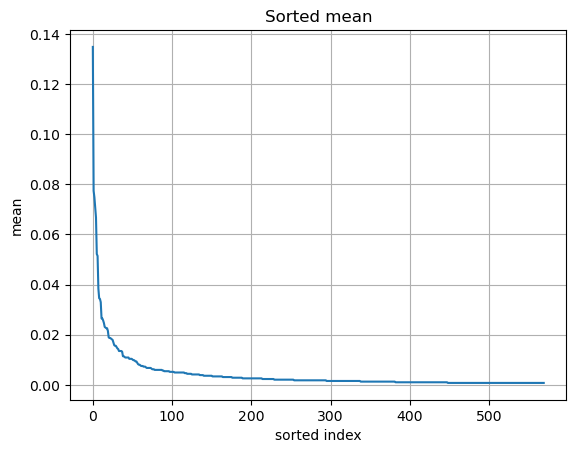

In [33]:
plt.plot(np.arange(df_desc.shape[1]), df_desc.loc['mean', :].sort_values(ascending=False))
plt.xlabel('sorted index')
plt.ylabel('mean')
plt.title('Sorted mean')
plt.grid()
plt.show()

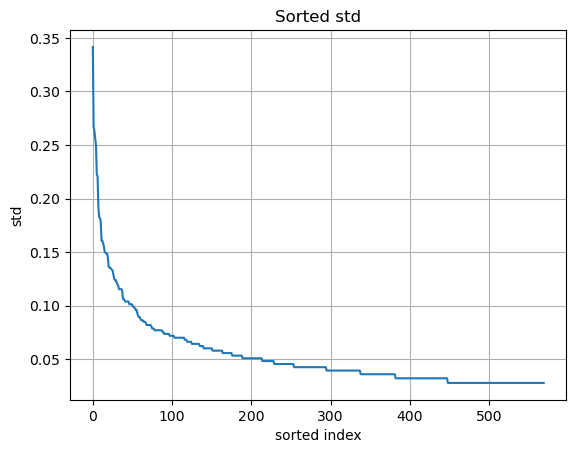

In [34]:
plt.plot(np.arange(df_desc.shape[1]), df_desc.loc['std', :].sort_values(ascending=False))
plt.xlabel('sorted index')
plt.ylabel('std')
plt.title('Sorted std')
plt.grid()
plt.show()

In [35]:
data = (data0-data0.mean())/data0.std()
data.describe()

,r P nb,mniw Nxn / zAw Nxn,imy-rA wabty,imy-rA 5maw,cmcw cnwt,xrp iAwt nbwt nTrwt,imy-rA prwy-nbw,imAxw,xrp aH,zA ncwt n Xt.f,...,zS pr-aA,zS pr-mDA(w)t,zS pr-mDAt nTr,zS pr-mDAt nTr pr-aA,zS qdw(t),zS wr(w) mD 5maw,zb,zb pr-aA,zwnw,zwnw pr-aA
count,3.849000e+03,3.849000e+03,3.849000e+03,3.849000e+03,3.849000e+03,3.849000e+03,3.849000e+03,3.849000e+03,3.849000e+03,3.849000e+03,...,3.849000e+03,3.849000e+03,3.849000e+03,3.849000e+03,3.849000e+03,3.849000e+03,3.849000e+03,3.849000e+03,3.849000e+03,3.849000e+03
mean,-7.384180e-18,2.953672e-17,-1.107627e-17,1.476836e-17,3.692090e-17,-2.215254e-17,-7.384180e-18,7.384180e-18,1.476836e-17,-5.538135e-18,...,8.768714e-18,-3.692090e-18,2.769068e-17,-1.569138e-17,7.384180e-18,-1.384534e-17,4.615113e-18,2.769068e-18,-1.846045e-17,-3.692090e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-7.752379e-02,-8.861952e-02,-7.580986e-02,-8.245711e-02,-7.042405e-02,-6.659710e-02,-7.226298e-02,-2.328468e-01,-1.203861e-01,-9.009620e-02,...,-3.950791e-02,-6.460024e-02,-4.267897e-02,-2.792541e-02,-3.950791e-02,-3.224968e-02,-2.792541e-02,-2.792541e-02,-4.267897e-02,-5.352879e-02
25%,-7.752379e-02,-8.861952e-02,-7.580986e-02,-8.245711e-02,-7.042405e-02,-6.659710e-02,-7.226298e-02,-2.328468e-01,-1.203861e-01,-9.009620e-02,...,-3.950791e-02,-6.460024e-02,-4.267897e-02,-2.792541e-02,-3.950791e-02,-3.224968e-02,-2.792541e-02,-2.792541e-02,-4.267897e-02,-5.352879e-02
50%,-7.752379e-02,-8.861952e-02,-7.580986e-02,-8.245711e-02,-7.042405e-02,-6.659710e-02,-7.226298e-02,-2.328468e-01,-1.203861e-01,-9.009620e-02,...,-3.950791e-02,-6.460024e-02,-4.267897e-02,-2.792541e-02,-3.950791e-02,-3.224968e-02,-2.792541e-02,-2.792541e-02,-4.267897e-02,-5.352879e-02
75%,-7.752379e-02,-8.861952e-02,-7.580986e-02,-8.245711e-02,-7.042405e-02,-6.659710e-02,-7.226298e-02,-2.328468e-01,-1.203861e-01,-9.009620e-02,...,-3.950791e-02,-6.460024e-02,-4.267897e-02,-2.792541e-02,-3.950791e-02,-3.224968e-02,-2.792541e-02,-2.792541e-02,-4.267897e-02,-5.352879e-02
max,1.289591e+01,1.128126e+01,1.318747e+01,1.212437e+01,1.419601e+01,1.501177e+01,1.383475e+01,4.293554e+00,8.304450e+00,1.109636e+01,...,2.530481e+01,1.547580e+01,2.342466e+01,3.580038e+01,2.530481e+01,3.100000e+01,3.580038e+01,3.580038e+01,2.342466e+01,1.867668e+01


In [36]:
# # Assuming your DataFrame is named df
# correlation_matrix = data.corr()# 

# # Plotting the correlation matrix using seaborn
# plt.figure(figsize=(6, 5))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
# plt.title('Correlation Matrix')
# plt.show()

In [37]:
n = 100
# Initialize PCA with 20 components
pca = PCA(n_components=n)
# Fit PCA to your data
pca.fit(data)
# Transform the data into the new 2-dimensional space
X = pca.transform(data)
# Convert the transformed data into a DataFrame
X = pd.DataFrame(X, columns=[f'PC{str(i+1).zfill(2)}' for i in range(n)], index=data.index)

In [38]:
print(data.shape)
print(X.shape)
X.head()

(3849, 570)
(3849, 100)


,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,PC10,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100
ID_person,,,,,,,,,,,,,,,,,,,,,
322,-0.934124,-0.367814,0.062110,0.078282,0.064600,0.222584,0.119743,0.068256,0.020339,0.235325,...,0.246081,-0.133197,0.119744,0.024687,0.040265,-0.039726,-0.000082,0.140004,0.047010,-0.140572
323,-1.005914,-0.603660,0.174834,0.031099,-0.122739,0.316966,-0.433983,0.167702,-0.116825,0.071307,...,-0.291729,-1.090297,0.808024,0.923074,-0.890074,-1.147233,-1.292183,2.008216,0.546104,-0.498797
324,-0.943885,-0.510171,0.135177,0.029774,-0.131088,0.250615,-0.345156,0.110766,-0.093676,0.081517,...,-0.016393,-0.043727,-0.065541,-0.028973,-0.014250,-0.007795,-0.044980,-0.033860,-0.007544,-0.047796
325,-0.985175,-0.553999,0.165047,0.021065,-0.130728,0.272077,-0.398351,0.115114,-0.101531,0.078938,...,0.074477,-0.217577,0.080616,0.023050,-0.503464,0.193349,-0.194421,0.109412,0.576103,0.202672
326,-0.985175,-0.553999,0.165047,0.021065,-0.130728,0.272077,-0.398351,0.115114,-0.101531,0.078938,...,0.074477,-0.217577,0.080616,0.023050,-0.503464,0.193349,-0.194421,0.109412,0.576103,0.202672


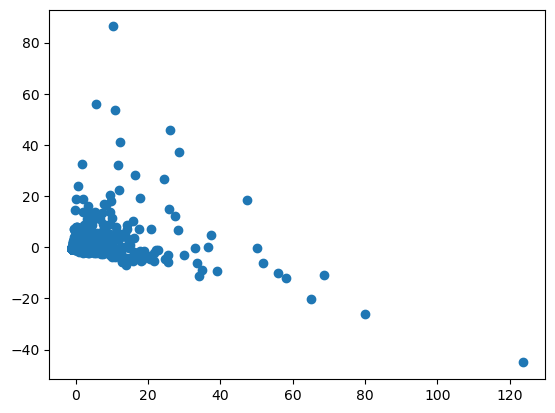

In [39]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1])

### Analyze decomposition

In [40]:
# Raw variance of each PC (the eigenvalues)
print("Explained variance (eigenvalues):")
#print(pca.explained_variance_)

# Proportion of variance explained by each PC
print("\nExplained variance ratio:")
#print(pca.explained_variance_ratio_)

# (Optional) Cumulative explained variance
import numpy as np
print("\nCumulative explained variance:")
#print(np.cumsum(pca.explained_variance_ratio_))


Explained variance (eigenvalues):

Explained variance ratio:

Cumulative explained variance:


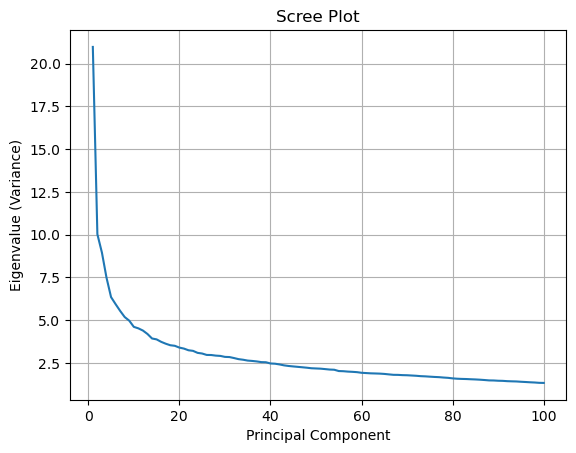

In [41]:
plt.plot(range(1, len(pca.explained_variance_)+1), pca.explained_variance_, marker='')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue (Variance)')
plt.title('Scree Plot')
plt.grid()
plt.show()

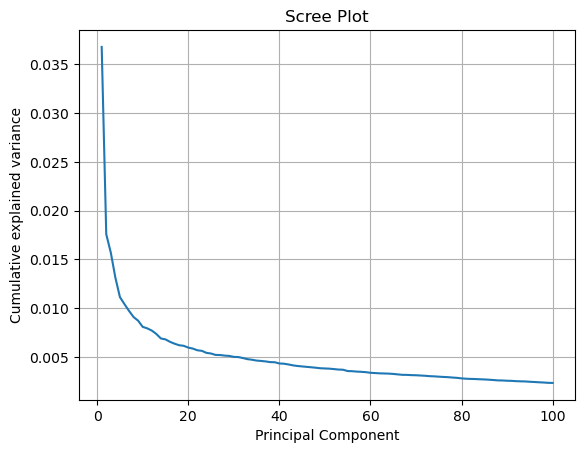

In [42]:
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative explained variance')
plt.title('Scree Plot')
plt.grid()
plt.show()

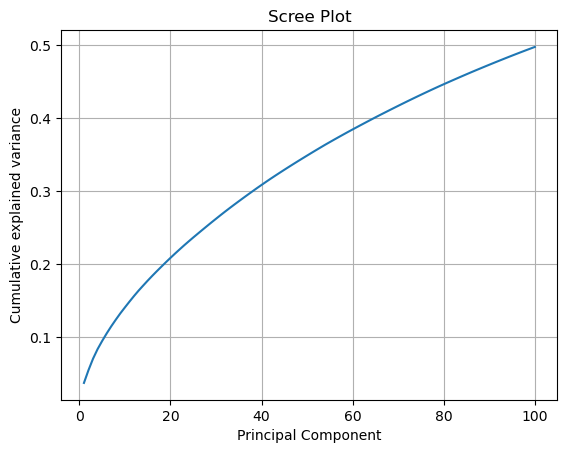

In [43]:
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), marker='')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative explained variance')
plt.title('Scree Plot')
plt.grid()
plt.show()

### save PCA df

In [44]:
df_X = X.reset_index(drop=False)
print(df_X.shape)
df_X.head()

(3849, 101)


,ID_person,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,PC09,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100
0,322,-0.934124,-0.367814,0.062110,0.078282,0.064600,0.222584,0.119743,0.068256,0.020339,...,0.246081,-0.133197,0.119744,0.024687,0.040265,-0.039726,-0.000082,0.140004,0.047010,-0.140572
1,323,-1.005914,-0.603660,0.174834,0.031099,-0.122739,0.316966,-0.433983,0.167702,-0.116825,...,-0.291729,-1.090297,0.808024,0.923074,-0.890074,-1.147233,-1.292183,2.008216,0.546104,-0.498797
2,324,-0.943885,-0.510171,0.135177,0.029774,-0.131088,0.250615,-0.345156,0.110766,-0.093676,...,-0.016393,-0.043727,-0.065541,-0.028973,-0.014250,-0.007795,-0.044980,-0.033860,-0.007544,-0.047796
3,325,-0.985175,-0.553999,0.165047,0.021065,-0.130728,0.272077,-0.398351,0.115114,-0.101531,...,0.074477,-0.217577,0.080616,0.023050,-0.503464,0.193349,-0.194421,0.109412,0.576103,0.202672
4,326,-0.985175,-0.553999,0.165047,0.021065,-0.130728,0.272077,-0.398351,0.115114,-0.101531,...,0.074477,-0.217577,0.080616,0.023050,-0.503464,0.193349,-0.194421,0.109412,0.576103,0.202672


In [45]:
print(f'{X.shape} original shape')
df_final = pd.merge(y_true, X, left_index=True, right_index=True, how='right')
df_final.reset_index(drop=False, inplace=True)
print(f'{df_final.shape} final shape')
df_final.head()

(3849, 100) original shape
(3849, 102) final shape


,ID_person,vizier,PC01,PC02,PC03,PC04,PC05,PC06,PC07,PC08,...,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100
0,322,0,-0.934124,-0.367814,0.062110,0.078282,0.064600,0.222584,0.119743,0.068256,...,0.246081,-0.133197,0.119744,0.024687,0.040265,-0.039726,-0.000082,0.140004,0.047010,-0.140572
1,323,0,-1.005914,-0.603660,0.174834,0.031099,-0.122739,0.316966,-0.433983,0.167702,...,-0.291729,-1.090297,0.808024,0.923074,-0.890074,-1.147233,-1.292183,2.008216,0.546104,-0.498797
2,324,0,-0.943885,-0.510171,0.135177,0.029774,-0.131088,0.250615,-0.345156,0.110766,...,-0.016393,-0.043727,-0.065541,-0.028973,-0.014250,-0.007795,-0.044980,-0.033860,-0.007544,-0.047796
3,325,0,-0.985175,-0.553999,0.165047,0.021065,-0.130728,0.272077,-0.398351,0.115114,...,0.074477,-0.217577,0.080616,0.023050,-0.503464,0.193349,-0.194421,0.109412,0.576103,0.202672
4,326,0,-0.985175,-0.553999,0.165047,0.021065,-0.130728,0.272077,-0.398351,0.115114,...,0.074477,-0.217577,0.080616,0.023050,-0.503464,0.193349,-0.194421,0.109412,0.576103,0.202672


In [46]:
# define final sets
df_train_v3 = df_final.loc[df_final['ID_person'].isin(person_id_train), :]
df_val_v3 = df_final.loc[df_final['ID_person'].isin(person_id_val), :]
df_test_v3 = df_final.loc[df_final['ID_person'].isin(person_id_test), :]

# save
save_df(df_final, 'df_vizier_title_v3_mod')
save_df(df_train_v3, 'df_vizier_title_train_v3_mod')
save_df(df_val_v3, 'df_vizier_title_val_v3_mod')
save_df(df_test_v3, 'df_vizier_title_test_v3_mod')

print(f'{df_final.shape}\t df_final shape')
print(f'{df_train_v3.shape}\t df_train_v3 shape')
print(f'{df_val_v3.shape}\t df_val_v3 shape')
print(f'{df_test_v3.shape}\t df_test_v3 shape')

Dataframe saved into C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\df_vizier_title_v3_mod.csv
Dataframe saved into C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\df_vizier_title_train_v3_mod.csv
Dataframe saved into C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\df_vizier_title_val_v3_mod.csv
Dataframe saved into C:\Users\Stoja\OneDrive\Documents\diplomka\scr\data\df_vizier_title_test_v3_mod.csv
(3849, 102)	 df_final shape
(2693, 102)	 df_train_v3 shape
(582, 102)	 df_val_v3 shape
(574, 102)	 df_test_v3 shape


In [47]:
print(f'{df_train.shape}\t df_train_v3 shape')
print(f'{df_val.shape}\t df_val_v3 shape')
print(f'{df_test.shape}\t df_test_v3 shape')

(2693, 43)	 df_train_v3 shape
(582, 43)	 df_val_v3 shape
(574, 43)	 df_test_v3 shape
